In [1]:
#!pip install selenium

# 1: Analyze the Fake News Dataset

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from cleantext import clean
from collections import Counter
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import json

In [3]:
data_cleaned = pd.read_csv("../Assignment 1/cleaned_data.csv")
display(data_cleaned.head())

,Unnamed: 0,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary
0,0,141,awm.com,unreliable,<URL>,sometimes the power of christmas will make you...,<DATE>,<DATE>,<DATE>,church congregation brings gift to waitresses ...,ruth harris,NaN,[''],NaN,NaN,NaN
1,1,256,beforeitsnews.com,fake,<URL>,awakening of <NUM> strands of dna – “reconnect...,<DATE>,<DATE>,<DATE>,awakening of <NUM> strands of dna – “reconnect...,zurich times,NaN,[''],NaN,NaN,NaN
2,2,700,cnnnext.com,unreliable,<URL>,never hike alone: a friday the 13th fan film u...,<DATE>,<DATE>,<DATE>,never hike alone - a friday the 13th fan film ...,NaN,NaN,[''],never hike alone: a friday the 13th fan film u...,NaN,NaN
3,3,768,awm.com,unreliable,<URL>,"when a rare shark was caught, scientists were ...",<DATE>,<DATE>,<DATE>,elusive ‘alien of the sea ‘ caught by scientis...,alexander smith,NaN,[''],NaN,NaN,NaN
4,4,791,bipartisanreport.com,clickbait,<URL>,donald trump has the unnerving ability to abil...,<DATE>,<DATE>,<DATE>,trump’s genius poll is complete & the results ...,gloria christie,NaN,[''],NaN,NaN,NaN


In [4]:
print("Unique article types:", data_cleaned['type'].unique())
print(data_cleaned['type'].value_counts())

Unique article types: ['unreliable' 'fake' 'clickbait' 'conspiracy' 'reliable' 'bias' 'hate'
 'junksci' 'political' nan 'unknown']
type
fake          155
conspiracy     31
political      23
unreliable      6
bias            6
junksci         6
unknown         6
reliable        3
clickbait       1
hate            1
Name: count, dtype: int64


In [5]:
category_mapping = {
    'fake': 'fake',
    'clickbait': 'fake',
    'unreliable': 'fake',
    'bias': 'fake',
    'reliable': 'reliable'
}
data_cleaned['label'] = data_cleaned['type'].map(category_mapping)
data_cleaned = data_cleaned.dropna(subset=['label'])
print(data_cleaned['label'].value_counts())

label
fake        168
reliable      3
Name: count, dtype: int64


label
fake        98.245614
reliable     1.754386
Name: proportion, dtype: float64


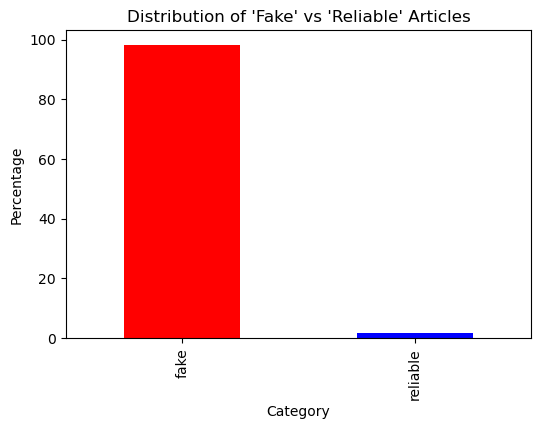

In [6]:
label_counts = data_cleaned['label'].value_counts(normalize=True) * 100
print(label_counts)

plt.figure(figsize=(6,4))
label_counts.plot(kind='bar', color=['red', 'blue'])
plt.xlabel("Category")
plt.ylabel("Percentage")
plt.title("Distribution of 'Fake' vs 'Reliable' Articles")
plt.show()

I decided to only count the articles tagged with "reliable" as reliable and discard everything that didn't seem like it was neccesarily fake news. This risks sorting away reliable articles which might be bad since the reliable articles already seem to be pretty scarce resulting in an unbalanced distrubution. It might be better to look into the discarded articles since better data gives better statistics. 

# 2: Gathering Links

In [7]:
# Test code :)
browser = webdriver.Firefox()
browser.get('https://www.bbc.com/news/world/europe')

In [8]:
def init_driver():
    options = webdriver.FirefoxOptions()
    options.add_argument("--headless")
    driver = webdriver.Firefox(options=options)
    return driver

In [9]:
def scroll_down(driver):
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(3)

In [10]:
def get_articles(driver, url):
    driver.get(url)
    time.sleep(5)  
    scroll_down(driver)
    articles_data = []
    try:
        WebDriverWait(driver, 10).until(
            EC.presence_of_all_elements_located((By.CSS_SELECTOR, '[data-testid="card-headline"]'))
        )
        article_elements = driver.find_elements(By.CSS_SELECTOR, '[data-testid="card-headline"]')
        for article in article_elements:
            try:
                headline = article.text.strip()
                summary_element = article.find_element(By.XPATH, "./following::p[@data-testid='card-description']")
                summary = summary_element.text.strip() if summary_element else "No summary"
                link_element = article.find_element(By.XPATH, "./ancestor::a[1]")
                link = link_element.get_attribute("href") if link_element else "No link"
                if link.startswith("/news/articles"):
                    link = "https://www.bbc.com" + link
                articles_data.append({"Headline": headline, "Summary": summary, "Link": link, "Region": url.split('/')[-1]})
            except:
                continue
    except:
        print("Error finding articles on page:", url)
    return articles_data

In [11]:
def scrape_multiple_regions(driver, base_urls, num_pages=5):
    all_articles = []
    for region, url in base_urls.items():
        print(f"Scraping region: {region}")
        # UK does not follow pagination or something idk
        if region == "UK":
            articles = get_articles(driver, url)
            all_articles.extend(articles)
            print(f"Scraped UK region, found {len(articles)} articles")
            continue
        for i in range(1, num_pages + 1):
            page_url = f"{url}/page/{i}"
            articles = get_articles(driver, page_url)
            all_articles.extend(articles)
            print(f"Scraped page {i} of {region}, found {len(articles)} articles")
    return all_articles

In [12]:
def save_articles(articles, csv_filename="articles.csv", json_filename="articles.json", txt_filename="articles.txt"):
    df = pd.DataFrame(articles)
    df.to_csv(csv_filename, index=False)
    print(f"Saved {len(articles)} articles to {csv_filename}")
    with open(json_filename, "w", encoding="utf-8") as json_file:
        json.dump(articles, json_file, indent=4)
    print(f"Saved {len(articles)} articles to {json_filename}")
    with open(txt_filename, "w", encoding="utf-8") as txt_file:
        for article in articles:
            txt_file.write(f"Headline: {article['Headline']}\nSummary: {article['Summary']}\nLink: {article['Link']}\nRegion: {article['Region']}\n\n")
    print(f"Saved {len(articles)} articles to {txt_filename}")

In [13]:
driver = init_driver()

base_urls = {
    "Europe": "https://www.bbc.com/news/world/europe",
    "US & Canada": "https://www.bbc.com/news/world/us_and_canada",
    "UK": "https://www.bbc.com/news/uk",
    "Australia": "https://www.bbc.com/news/world/australia",
    "Asia": "https://www.bbc.com/news/world/asia",
    "Africa": "https://www.bbc.com/news/world/africa",
    "Latin America": "https://www.bbc.com/news/world/latin_america",
    "Middle East": "https://www.bbc.com/news/world/middle_east"
}

articles = scrape_multiple_regions(driver, base_urls, num_pages=5)
save_articles(articles)

driver.quit()

Scraping region: Europe
Scraped page 1 of Europe, found 9 articles
Scraped page 2 of Europe, found 9 articles
Scraped page 3 of Europe, found 9 articles
Scraped page 4 of Europe, found 9 articles
Scraped page 5 of Europe, found 9 articles
Scraping region: US & Canada
Scraped page 1 of US & Canada, found 9 articles
Scraped page 2 of US & Canada, found 9 articles
Scraped page 3 of US & Canada, found 9 articles
Scraped page 4 of US & Canada, found 9 articles
Scraped page 5 of US & Canada, found 9 articles
Scraping region: UK
Scraped UK region, found 37 articles
Scraping region: Australia
Scraped page 1 of Australia, found 9 articles
Scraped page 2 of Australia, found 9 articles
Scraped page 3 of Australia, found 9 articles
Scraped page 4 of Australia, found 9 articles
Scraped page 5 of Australia, found 9 articles
Scraping region: Asia
Scraped page 1 of Asia, found 9 articles
Scraped page 2 of Asia, found 9 articles
Scraped page 3 of Asia, found 9 articles
Scraped page 4 of Asia, found 9 a

# 3: Scraping Article Text

In [14]:
df = pd.read_csv("articles.csv", encoding="utf-8")
df.columns = df.columns.str.strip()
print(df.columns)

# Le epic debugging cause I couldn't figure out how to import the data lule
link_column = [col for col in df.columns if 'link' in col.lower()]
print("Detected Link Column:", link_column)

# Extract links if found
if link_column:
    article_links = df[link_column[0]].tolist()
    print(f"Successfully extracted {len(article_links)} article links.")
else:
    print("Error: Could not find a column containing 'link'.")

link_column = [col for col in df.columns if 'link' in col.lower()]

Index(['Headline', 'Summary', 'Link', 'Region'], dtype='object')
Detected Link Column: ['Link']
Successfully extracted 352 article links.


In [15]:
def scrape_article(driver, url):
    try:
        driver.get(url)
        time.sleep(3)
        # Extract headline
        headline = driver.find_element(By.TAG_NAME, "h1").text
        # Extract article text (doesn't capture everything sadly)
        try:
            article_container = driver.find_element(By.CSS_SELECTOR, "[data-component='text-block']")
            paragraphs = article_container.find_elements(By.TAG_NAME, "p")
            article_text = " ".join([p.text for p in paragraphs if p.text])
        except:
            article_text = "Article text not found"
        # Remove cookie disclaimers
        unwanted_phrases = [
            "We use cookies to give you the best online experience.",
            "Please let us know if you agree to all of these cookies."
        ]
        for phrase in unwanted_phrases:
            article_text = article_text.replace(phrase, "").strip()
        try:
            date_element = driver.find_element(By.TAG_NAME, "time")
            published_date = date_element.get_attribute("datetime") or date_element.text
        except:
            published_date = "Unknown"
        # Trying to find the author here but it ain't working xd
        author = "Unknown"
        try:
            byline_container = driver.find_element(By.CSS_SELECTOR, "[data-testid='byline-new']")
            author_span = byline_container.find_elements(By.TAG_NAME, "span")
            if author_span:
                author = author_span[0].text.strip()
        except:
            try:
                author_elements = driver.find_elements(By.TAG_NAME, "span")
                for elem in author_elements:
                    if "by" in elem.text.lower() and len(elem.text.split()) < 5:
                        author = elem.text.strip()
                        break
            except:
                author = "Unknown"
        return {
            "URL": url,
            "Headline": headline,
            "Published Date": published_date,
            "Author": author,
            "Article Text": article_text
        }
    except Exception as e:
        print(f"Error scraping {url}: {e}")
        return None

In [16]:
def scrape_all_articles(driver, article_links):
    all_articles = []
    for index, url in enumerate(article_links):
        print(f"Scraping article {index+1}/{len(article_links)}: {url}")
        article_data = scrape_article(driver, url)
        if article_data:
            all_articles.append(article_data)
    return all_articles

In [17]:
def save_articles(articles, filename="scraped_articles.csv"):
    df = pd.DataFrame(articles)
    df.to_csv(filename, index=False)
    print(f"Saved {len(articles)} articles to {filename}")

In [18]:
driver = init_driver()
article_links = pd.read_csv("articles.csv")["Link"].tolist()

#scraped_articles = scrape_all_articles(driver, article_links[:20])  # Test with 20 articles
scraped_articles = scrape_all_articles(driver, article_links)
save_articles(scraped_articles, "scraped_articles.csv")

driver.quit()

Scraping article 1/352: https://www.bbc.com/news/articles/c7571ykv1p7o
Scraping article 2/352: https://www.bbc.com/news/articles/cz61nv49872o
Scraping article 3/352: https://www.bbc.com/news/articles/czjep2xyk7ko
Scraping article 4/352: https://www.bbc.com/sport/football/articles/cy87vww6n31o
Scraping article 5/352: https://www.bbc.com/news/articles/c62ze617p5eo
Scraping article 6/352: https://www.bbc.com/news/articles/c241rnqgp09o
Scraping article 7/352: https://www.bbc.com/cymrufyw/erthyglau/cx2rp738exlo
Scraping article 8/352: https://www.bbc.com/news/articles/c3vw33g2lxxo
Scraping article 9/352: https://www.bbc.com/news/articles/cnvze9dzq8vo
Scraping article 10/352: https://www.bbc.com/news/articles/c7571ykv1p7o
Scraping article 11/352: https://www.bbc.com/news/articles/cz61nv49872o
Scraping article 12/352: https://www.bbc.com/news/articles/czjep2xyk7ko
Scraping article 13/352: https://www.bbc.com/sport/football/articles/cy87vww6n31o
Scraping article 14/352: https://www.bbc.com/new

To determine whether the scraped data should be included in the dataset we need to assess its quality completeness and relevance. Only 352 out of 800 expected articles have been scraped which means that 56% of the dataset is missing. This could lead to bias. 

Furthermore the scraping didn't seem to include authors and all of the text from the articles. 

With this in mind we would think the data is of too low quality to include in the original dataset but the original dataset had so few reliable articles that I suspect it wasn't of high quality at all anyways.